In [8]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [9]:
import numpy as np
import argparse, sys, os, errno
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from unet_128_model_row_column import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [11]:
model = UNET_128()
optim = Adam()
model.compile(optimizer=optim, loss=binary_crossentropy_with_nan, metrics=[binary_accuracy_with_nan,mse_with_nan])
# last activation output(None,128,128,1)
#want: (None,128)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
#the y size will be 256

In [17]:
with h5py.File('/home/chenxupeng/projects/deepshape/data/new/train_1') as f:
    images_train = f['train_images'][:1000]
with h5py.File('/home/chenxupeng/projects/deepshape/data/new/test_0') as f:
    images_test= f['test_images'][:1000]
with h5py.File('/home/chenxupeng/projects/deepshape/data/new/Spitale_2015_invivo_CDS_0.1') as f:
    y_train = f['y_train'][:1000]
    y_test = f['y_test'][:1000]
y_train = np.concatenate([y_train,y_train],axis = 1)
y_test= np.concatenate([y_test,y_test],axis = 1)

In [7]:
'''
a = np.ndarray([y_train.shape[0],])
for i in range(y_train.shape[0]):
    a[i] = np.sum(np.isnan(y_train[i]))
%pylab inline
hist(a,bins = 50)
'''

'\na = np.ndarray([y_train.shape[0],])\nfor i in range(y_train.shape[0]):\n    a[i] = np.sum(np.isnan(y_train[i]))\n%pylab inline\nhist(a,bins = 50)\n'

In [47]:
#callbacks = [model_checkpoint]
model_checkpoint = ModelCheckpoint('output/newunet_row_col.hdf5', monitor='binary_accuracy_with_nan', save_best_only=True)

In [48]:
def Model(images_train,images_test,y_train,y_test_true,count):
    model.fit(images_train, y_train, batch_size=16, nb_epoch=50,
              verbose=1, shuffle=True,validation_split=0.2,
              callbacks=[model_checkpoint,EarlyStopping(monitor='binary_crossentropy', patience=10, verbose=0),TensorBoard(log_dir='/home/chenxupeng/projects/deepshape/output/tensorboard/unet/log_dir')])
    num_test = images_test.shape[0]
    y_test = np.ndarray([num_test,256],dtype=np.float32)
    predict = model.predict([images_test], verbose=0)
    for i in tqdm(range(num_test)):
        y_test[i] = predict[i]
    np.save('/home/chenxupeng/projects/deepshape/output/unet_row_col_predict'+str(count)+'.npy', y_test)
    acc = 0.0
    y_test[np.where(y_test >= 0.5)] = 1
    y_test[np.where(y_test < 0.5)] = 0
    for i in range(num_test):
        accu = 0.0
        index = np.where(np.isnan(y_test[i]) ==0)[0]
        count = index.shape[0]
        for j in range(count):
            if y_test[i][index][j] == y_test_true[i][index][j]:
                accu +=1
        accu /=float(count) 
        acc +=accu
    acc /=num_test
    print("accuracy : ",acc)
    model.save('output/newunet_row_col.hdf5')
    model.save_weights('output/newunet__row_col_weights.hdf5')
    return acc

In [49]:
y_train.shape

(1000, 256)

In [50]:
number = 1000
for i in range(1):
    acc = Model(images_train[:number,:,:,:],images_test[:number,:,:,:],y_train[:number,:],y_test[:number,:],i)

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 16s 19ms/step - loss: 7.8927 - binary_accuracy_with_nan: 0.5140 - mse_with_nan: 0.2800 - val_loss: 8.1809 - val_binary_accuracy_with_nan: 0.4861 - val_mse_with_nan: 0.4778
Epoch 2/50
800/800 [==============================] - 11s 14ms/step - loss: 7.7950 - binary_accuracy_with_nan: 0.5300 - mse_with_nan: 0.2738 - val_loss: 7.7801 - val_binary_accuracy_with_nan: 0.5254 - val_mse_with_nan: 0.3856
Epoch 3/50
800/800 [==============================] - 10s 12ms/step - loss: 7.7983 - binary_accuracy_with_nan: 0.5289 - mse_with_nan: 0.2737 - val_loss: 7.9983 - val_binary_accuracy_with_nan: 0.5006 - val_mse_with_nan: 0.2870
Epoch 4/50
800/800 [==============================] - 11s 14ms/step - loss: 7.7430 - binary_accuracy_with_nan: 0.5391 - mse_with_nan: 0.2666 - val_loss: 8.0309 - val_binary_accuracy_with_nan: 0.4980 - val_mse_with_nan: 0.2971
Epoch 5/50
800/800 [==============================

Epoch 37/50
800/800 [==============================] - 11s 14ms/step - loss: 4.2828 - binary_accuracy_with_nan: 0.7929 - mse_with_nan: 0.1531 - val_loss: 7.7999 - val_binary_accuracy_with_nan: 0.5193 - val_mse_with_nan: 0.3563
Epoch 38/50
800/800 [==============================] - 11s 14ms/step - loss: 4.1682 - binary_accuracy_with_nan: 0.7985 - mse_with_nan: 0.1484 - val_loss: 7.9673 - val_binary_accuracy_with_nan: 0.5043 - val_mse_with_nan: 0.3453
Epoch 39/50
800/800 [==============================] - 12s 14ms/step - loss: 4.0466 - binary_accuracy_with_nan: 0.8060 - mse_with_nan: 0.1430 - val_loss: 7.6401 - val_binary_accuracy_with_nan: 0.5354 - val_mse_with_nan: 0.3584
Epoch 40/50
800/800 [==============================] - 12s 15ms/step - loss: 4.0335 - binary_accuracy_with_nan: 0.8077 - mse_with_nan: 0.1425 - val_loss: 7.8100 - val_binary_accuracy_with_nan: 0.5107 - val_mse_with_nan: 0.3314
Epoch 41/50
800/800 [==============================] - 12s 15ms/step - loss: 3.9351 - binary

100%|██████████| 1000/1000 [00:00<00:00, 424267.04it/s]


('accuracy : ', 0.0491171875)


In [30]:
b = np.load('/home/chenxupeng/projects/deepshape/output/unet_predict0.npy')

In [44]:
from keras.models import load_model
model = load_model('output/newunet.hdf5')

In [101]:
weights = h5py.File('output/newunet_weights_1.hdf5')

(array([ 1.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,
         2.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  2.]),
 array([-0.402661  , -0.38678174, -0.37090249, -0.35502324, -0.33914399,
        -0.32326473, -0.30738548, -0.29150623, -0.27562698, -0.25974772,
        -0.24386847, -0.22798922, -0.21210997, -0.19623071, -0.18035146,
        -0.16447221, -0.14859295, -0.1327137 , -0.11683445, -0.1009552 ,
        -0.08507594, -0.06919669, -0.05331744, -0.03743819, -0.02155893,
        -0.00567968,  0.01019957,  0.02607882,  0.04195808,  0.05783733,
         0.07371658,  0.08959583,  0.10547509,  0.12135434,  0.13723359,
         0.15311284,  0.1689921 ,  0.18487135,  0.2007506 ,  0.21662985,
         0.23250911,  0.24838836,  0.26426761,  0.28014686,  0.29602612,
         0.31190537,  0.32778462,  0.34366387,  0.35954313,

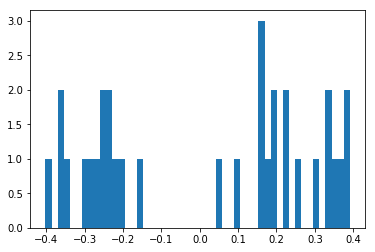

In [120]:
hist(weights['conv2d_69/conv2d_69/kernel:0'][:].flatten(),bins =50)

In [91]:
#model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 128, 128, 32) 4640        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 128, 128, 32) 128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 128, 128, 32) 0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [64]:
np.abs(weights[0]).flatten()

array([ 0.04075397,  0.05833072,  0.00320405, ...,  0.07187954,
        0.04653677,  0.07539184], dtype=float32)

In [66]:
np.max(np.abs(weights[0]).flatten())

0.31577942

In [32]:
c = {}
for i in range(1000):
    index = np.where(np.isnan(y_test[i]) ==0)[0]
    c[i] = b[i][index]

In [34]:
c[1]

array([ 0.07683542,  0.99696356,  0.58331442,  0.00804483,  0.93075985], dtype=float32)

In [17]:
a = {}
for i in range(1000):
    index = np.where(np.isnan(y_test[i]) ==0)[0]
    a[i] = y_test[i][index]

In [35]:
a[0]

array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.], dtype=float32)

In [21]:
count_0 = {}
count_1 = {}
ratio = {}
for i in range(1000):
    whole = a[i].shape[0]
    count_1[i] = np.sum(a[i])
    count_0[i] = whole -count_1[i]
#正样本的比例
    ratio[i] = count_1[i] / whole

In [25]:
ratio_ = np.array([val for key,val in ratio.iteritems()])
count_1_ = np.array([val for key,val in count_1.iteritems()])
count_0_ = np.array([val for key,val in count_0.iteritems()])

In [29]:
np.sum(count_1_)/(np.sum(count_1_)+np.sum(count_0_))

0.5087093899376165

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 59.,   0.,   2.,   8.,   5.,  14.,  10.,  19.,  14.,   7.,  28.,
         27.,  41.,  21.,  26.,  29.,  38.,  15.,  25.,  20.,  37.,  26.,
         24.,  11.,   0.,  78.,  21.,  20.,  23.,   6.,  33.,  23.,  11.,
         26.,  27.,  16.,  12.,  16.,  13.,   3.,  28.,  16.,  20.,  17.,
          8.,  23.,  10.,   8.,   1.,  35.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

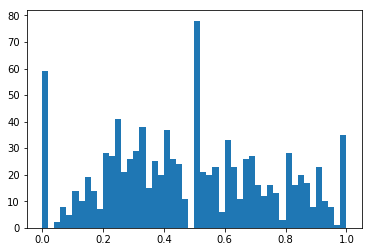

In [24]:
hist(ratio_,bins =50)

In [3]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [12]:
#analyze model output

In [13]:
from keras.models import load_model
model = load_model('output/newunet_row_col.hdf5')
model.summary()

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

In [18]:
# Testing
layer_outs = functor([images_test[:50], 1.])

In [19]:
layer_outs[94].shape

(50, 128, 128, 1)

In [20]:
#存一下输出
with h5py.File('newunet_row_col_output_1') as f:
    for i in range(102):
        f.create_dataset(str(i),data = layer_outs[i])

In [21]:
for i in range(1):
    print layer_outs[i].shape
#92 layers 

(50, 128, 128, 16)


In [22]:
layer_outs[94].shape

(50, 128, 128, 1)

In [23]:
def check_sym(array):
    out = ((array - array.T) ** 2).mean(axis=None)
    return out

In [24]:
mse = {}
for i in range(95):
    mse[i] = {}
    shape = layer_outs[i].shape
    for j in range(shape[0]):
        mse[i][j] = {}
        for t in range(shape[3]):
            mse[i][j][t]=check_sym(layer_outs[i][j,:,:,t])

In [25]:
#转换一层的dict to array
def dict_array(dict,t):
    array = np.ndarray([50,len(mse[t][0])])
    for i in range(len(mse[t])):
        array[i] = np.array([val for key,val in np.array([val for key,val in mse[t].iteritems()])[i].iteritems()])
    array = array.flatten()
    return array

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate', 'f', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 1.,  0.,  2.,  1.,  2.,  1.,  2.,  3.,  0.,  0.,  2.,  1.,  1.,
         0.,  0.,  0.,  2.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,
         2.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,
         1.,  0.,  4.,  1.,  2.,  1.,  0.,  0.,  1.,  0.,  2.]),
 array([ 0.00188877,  0.00812846,  0.01436814,  0.02060783,  0.02684752,
         0.03308721,  0.0393269 ,  0.04556658,  0.05180627,  0.05804596,
         0.06428565,  0.07052534,  0.07676502,  0.08300471,  0.0892444 ,
         0.09548409,  0.10172378,  0.10796346,  0.11420315,  0.12044284,
         0.12668253,  0.13292222,  0.13916191,  0.14540159,  0.15164128,
         0.15788097,  0.16412066,  0.17036035,  0.17660003,  0.18283972,
         0.18907941,  0.1953191 ,  0.20155879,  0.20779847,  0.21403816,
         0.22027785,  0.22651754,  0.23275723,  0.23899691,  0.2452366 ,
         0.25147629,  0.25771598,  0.26395567,  0.27019536,  0.27643504,
         0.28267473,  0.28891442,  0.29515411,  0.3013938 ,

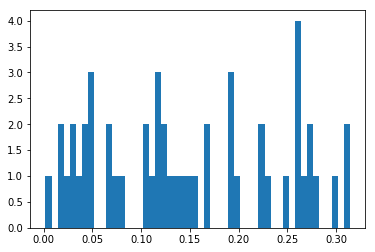

In [27]:
hist(dict_array(mse,94),bins = 50)

In [41]:
#model.summary()

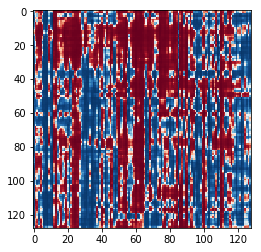

In [28]:
#imshow 查看输出  94  91
imshow(layer_outs[94][3,:,:,0],cmap=cm.RdBu_r)